In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np

# plotting
import matplotlib  as mpl
import matplotlib.pylab as plt
# our packages
from pharaglow import extract, util
from pharaglow.util import smooth

In [2]:
# matplotlib settings to make stuff nice. This can also be imported using a style sheet.


##### Figure 1 Preemptive pumping requires bacterial odors  
- establishing preemptive pumping: In wild type (GRU101) for 24 and 1h(?) lawns. Here we can use the Zeiss data and then say we wanted to upscale to larger N -> macroscopes.
- (A) experimental setup biorender
- (B) and (C) Wildtype lawn encounter velocity and pumping rate
- (D) comparison GRU101 on short and long-term lawn (maybe a theoretical calculation of odor diffusion from luis would be nice to have). Can be added late. A quick back of the envelope calculation says the 24h should have 6mm diffusion only. This is pretty cool because then we should see how it differs between 24h and no incubation.)
- (E) Summary statistics for D 
- (F) worms that can’t smell


### Define convencience functions for data loading

In [3]:
def plotPumpAnalysis(pump, ps, roc, prs, time, metric):
    nt = len(prs)
    npeaks = [len(p) for p in ps]
    # plot the roc curve
    plt.figure('Analysis', figsize=(12,8))
    plt.subplot(221)
    plt.plot(prs, [len(p) for p in ps])
    plt.ylabel('Number of peaks')
    plt.xlabel('peak prominence parameter')
    plt.subplot(222)
    for ind, i in enumerate([0,nt//2, nt-1]):
        plt.text(time.iloc[0], pump[0] + 3*ind+1.2, 'prominence = {:.2}'.format(prs[i]))
        plt.plot(time, pump + 3*ind, color ='navy', lw = 0.25)
        plt.plot(time.iloc[ps[i]], pump[ps[i]] + 3*ind,'r.')
    plt.ylim(-2, 8)
    plt.yticks([])
    plt.xlabel('Time (frames)')
    plt.subplot(223)
    for ind, i in enumerate(range(0,nt,5)):
        plt.plot(ps[i]+time.iloc[0], np.arange(len(ps[i])), color ='k', alpha=0.2+0.8*i/len(prs), lw=0.75)
    plt.plot(ps[np.argmin(metric)]+time.iloc[0], np.arange(len(ps[np.argmin(metric)])), lw = 2, color='g')
    plt.ylabel('Cumulative peaks found')
    plt.xlabel('Time (frames)')
    plt.subplot(224)
    plt.plot(npeaks, metric)
    plt.plot(npeaks[np.argmin(metric)], np.min(metric), 'ro')
    print(len(ps[np.argmin(metric)]))
    plt.xlabel('Number of peaks')
    plt.ylabel('peak disimilarity')
    #[plt.plot(np.std(r, axis =1)) for r in roc]
    plt.tight_layout()

In [4]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(pumps, ws = 30, prs = np.linspace(0.5,0.95,50) ):
    return extract.bestMatchPeaks(pumps, ws, prs)

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

def readData(dataFolder, umPerPx, fps, j = 0):
    df = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            if particle_index not in [5,7]:
                continue
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            # pumping related data
            kymo = getKymo(traj, 'Straightened')
            rawPump = [-np.max(np.std(sIm, axis =1), axis =0) for sIm in traj['Straightened']]
            traj['pump'] = rawPump
            prs =  np.linspace(0.1,1.25,50)
            p, pump, pks, roc, metric  = getPumps(traj['pump'].values, prs = prs)
            plotPumpAnalysis(pump, pks, roc, prs, time = traj['frame'], metric=metric)
            pinterp = np.interp(traj['frame'], p[:-1], fps/np.diff(p))
            # get a binary trace where pumps are 1 and non-pumps are 0
            tmp = np.zeros(len(t))
            tmp[p] = 1
            
            df[j] = {'time': t,
                     'x': traj['x'],
                     'y': traj['y'],
                             'velocity':v,
                             'peaks': p,
                             'pumpTrace':pump,
                             'binaryPumps': tmp,
                             'pumpInterp': pinterp,
                             'inside': traj['inside'],
                             'insideF': traj['insideHeadIntensity'],
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo,
                             'fps': fps,
                             'scale':umPerPx
                            }
            j +=1
    return df

### Read relevant data

Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_14.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_8.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_15.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_16.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_17.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_19.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_2.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047

/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'


834
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_6.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_7.json


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future beha

811
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_0.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_1.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_11.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_12.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_13.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_14.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_2.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0

/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecat

571
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_6.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_7.json


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecat

819
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_8.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200320_NZ0045_test_results_9.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_0.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_1.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_10.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_11.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_12.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ00

/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecat

491
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200327_NZ0051_test_results_7.json


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecat

4
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200327_NZ0051_test_results_8.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200327_NZ0051_test_results_9.json
CPU times: user 1min 30s, sys: 6.66 s, total: 1min 37s
Wall time: 1min 37s


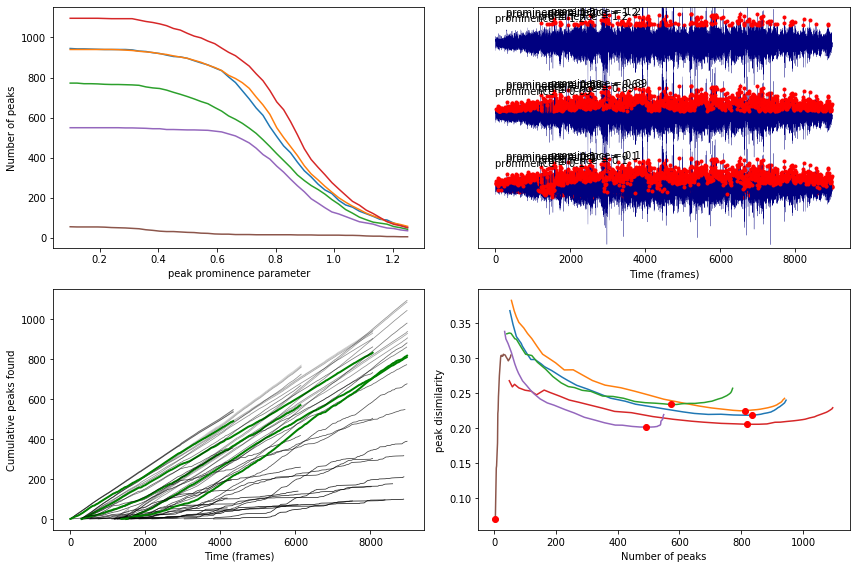

In [5]:
%%time
# some parameters
# FPS?
fps = 30
# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

# for this figure we need GRU101 control data
ctrl = "/media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/"
# Making dictionary combining data with strain name in their separate master folders
Data = {}
for strainName, folder in zip(['Control', 'INF100'], [ctrl]):
    Data[strainName] = readData(folder, umPerPx, fps)


In [6]:
### Helper functions to generate aligned velocity and pumping data
def alignData(df, tBefore, tAfter):
    """df is a dictionary created in readData. We will find the point of lawn entry and align and crop data to
    tBefore, TAfter. tBefore, tAfter are in frames."""
    for idx in df.keys():
        # identify the inside point t0 or set a flag that it doesn't enter
        try:
            # t0 is in frames not seconds!
            t0 = np.where(df[idx]['inside'] ==1)[0][0]
            print(t0, np.mean(df[idx]['inside']))
            if t0 > tBefore and len(df[idx]['inside']) > t0+tAfter:
                # update the data
                df[idx]['t0'] = t0
                df[idx]['enter'] = True
            else:
                df[idx]['t0'] = None
                df[idx]['enter'] = False
        except IndexError:
            df[idx]['t0'] = None
            df[idx]['enter'] = False
        # calculate cropped versions of the data for animals that entered the lawn
        if df[idx]['enter']:
            df[idx]['insideFCut'] = df[idx]['insideF'][df[idx]['t0']-tBefore: df[idx]['t0']+tAfter+1]
            df[idx]['vCut'] = df[idx]['velocity'][df[idx]['t0']-tBefore: df[idx]['t0']+tAfter+1]
            df[idx]['tCut'] = df[idx]['time'][df[idx]['t0']-tBefore: df[idx]['t0']+tAfter+1]
            df[idx]['pumpCut'] = df[idx]['pumpTrace'][df[idx]['t0']-tBefore: df[idx]['t0']+tAfter+1]
            df[idx]['binaryPumpsCut'] = df[idx]['binaryPumps'][df[idx]['t0']-tBefore: df[idx]['t0']+tAfter+1]
            # crop the peaks too
            df[idx]['peaksCut'] = df[idx]['peaks'][(df[idx]['peaks'] > df[idx]['t0']-tBefore)&
                                    (df[idx]['peaks'] < df[idx]['t0']+tAfter+1)].values
            df[idx]['peaksCut'] =  df[idx]['peaksCut'] - df[idx]['t0']+tBefore
            df[idx]['timeEntry'] = np.arange(-tBefore, tAfter+1)
            df[idx]['tBefore'] = tBefore
            df[idx]['tAfter'] = tAfter
    return df
    
    

### Setting up the figure layout using gridspec

In [10]:
tBefore=1*60*30
tAfter=10*30
df = alignData(Data['Control'], tBefore=tBefore, tAfter=tAfter)

1336 0.7568466854363962
829 0.5565749235474006
1957 0.6668369084099421
3069 0.565921052631579
1133 0.2614889705882353


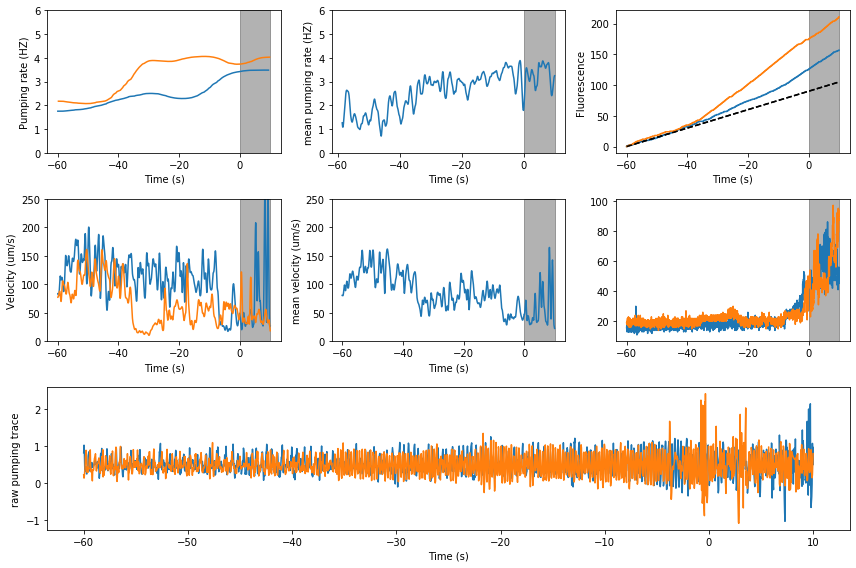

In [16]:
f1 = plt.figure("Lawn Entry", figsize=(12,8))
grid = mpl.gridspec.GridSpec(ncols=3, nrows =3)
ax1 = f1.add_subplot(grid[0,0])
ax2 = f1.add_subplot(grid[1,0])

# plot individual traces
for idx in df.keys():
    if df[idx]['enter']:
        # pumping rate
        pr = 30./np.diff(df[idx]['peaksCut'])
        ax1.plot(df[idx]['timeEntry'][df[idx]['peaksCut']][:-1]/df[idx]['fps'], util.smooth(pr, 60))
        ax2.plot(df[idx]['timeEntry']/df[idx]['fps'], util.smooth(df[idx]['vCut'], 30))
# mark entry
ax1.axvspan( 0, tAfter/fps, color='k', alpha=0.3)
ax2.axvspan( 0, tAfter/fps, color='k', alpha=0.3)
# label properly
ax1.set(ylabel='Pumping rate (HZ)', xlabel='Time (s)', ylim=(0,6))
ax2.set(ylabel='Velocity (um/s)', xlabel='Time (s)', ylim=(0,250))

# plot aggregate mean data
ax3 = f1.add_subplot(grid[0,1])
ax4 = f1.add_subplot(grid[1,1])
t, v, pr, f = [], [], [], []
for idx in df.keys():
    if df[idx]['enter']:
        # pumping rate using rolling mean rate in a rolling 1 second window
        tmp = pd.Series(df[idx]['binaryPumpsCut']).rolling(fps).sum()
        t.append(df[idx]['timeEntry']/df[idx]['fps'])
        pr.append(tmp)
        v.append(df[idx]['vCut'])
        f.append(df[idx]['insideFCut']/np.max(df[idx]['insideFCut']))

# make means and plot
ax3.plot(np.mean(t, axis=0), util.smooth(np.mean(pr, axis = 0),30))
ax4.plot(np.mean(t, axis=0), util.smooth(np.mean(v, axis = 0), 30))


# mark entry
ax3.axvspan( 0, tAfter/fps, color='k', alpha=0.3)
ax4.axvspan( 0, tAfter/fps, color='k', alpha=0.3)
# set labels
ax3.set(ylabel='mean pumping rate (HZ)', xlabel='Time (s)', ylim=(0,6))
ax4.set(ylabel='mean velocity (um/s)', xlabel='Time (s)', ylim=(0,250))

# plot sanity checks
ax5 = f1.add_subplot(grid[0,2])
ax6 = f1.add_subplot(grid[1,2])
ax7 = f1.add_subplot(grid[2,:])
for idx in df.keys():
    if df[idx]['enter']:
        # puming rate
        ax7.plot(df[idx]['timeEntry']/df[idx]['fps'], df[idx]['pumpCut'])
        ax5.plot(df[idx]['timeEntry']/df[idx]['fps'], np.cumsum(df[idx]['binaryPumpsCut']))
        # plot an average pumping rate line at 2.5 hz
        ax5.plot(df[idx]['timeEntry']/df[idx]['fps'], 1.5*(df[idx]['timeEntry']+tBefore)/df[idx]['fps'], 'k--')
        # plot lawn intensity
        ax6.plot(df[idx]['timeEntry']/df[idx]['fps'], df[idx]['insideFCut'])

# mark entry
ax5.axvspan( 0, tAfter/fps, color='k', alpha=0.3)
ax6.axvspan( 0, tAfter/fps, color='k', alpha=0.3)
# set labels
ax5.set(ylabel='cumulative pumps', xlabel='Time (s)')
ax5.set(ylabel='Fluorescence', xlabel='Time (s)')
ax7.set(ylabel='raw pumping trace', xlabel='Time (s)')
#
plt.tight_layout()

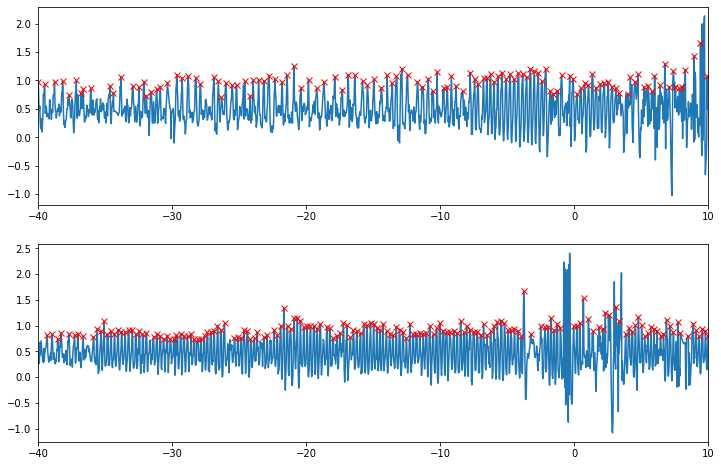

In [14]:

f1 = plt.figure("Lawn Entry", figsize=(12,8))
i = 1
for idx in df.keys():
    if df[idx]['enter']:
        # pumping rate
        plt.subplot(2,1,i)
        plt.plot(df[idx]['timeEntry']/df[idx]['fps'], df[idx]['pumpCut'])
        plt.plot(df[idx]['timeEntry'][df[idx]['peaksCut']]/df[idx]['fps'], df[idx]['pumpCut'][df[idx]['peaksCut']], 'rx')
        i+=1
        plt.xlim(-40,10)